In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, roc_curve, precision_score, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay, f1_score

In [78]:
#Load dataset
dfi = pd.read_csv("data/invoice_train.csv")
dfc = pd.read_csv("data/client_train.csv")

/var/folders/vh/9svjskkn54n5t04bltkc_8fw0000gn/T/ipykernel_11670/253326080.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  dfi = pd.read_csv("data/invoice_train.csv")


In [79]:
dfi.drop('invoice_date', axis=1, inplace=True)

In [80]:
# we check the values for certain columns and decider, wether we transform them to categorical or not.
dfi.tarif_type= dfi.tarif_type.astype('category')
dfi.counter_type = dfi.counter_type.astype('category')
dfi.counter_code = dfi.counter_code.astype('category')
dfi.reading_remarque = dfi.reading_remarque.astype('category')

# some columns can be reduced to int8, to save memory.
dfi.counter_coefficient = dfi.counter_coefficient.astype('int8')
dfi.months_number = dfi.months_number.astype('int16')

dfi.consommation_level_4 = dfi.consommation_level_4.astype('int32')
dfi.consommation_level_3 = dfi.consommation_level_3.astype('int32')
dfi.consommation_level_2 = dfi.consommation_level_2.astype('int32')
dfi.consommation_level_1 = dfi.consommation_level_1.astype('int32')

# dfi.counter_statue.value_counts()
dfi.counter_statue = dfi.counter_statue.astype('category')

In [81]:

dfi.drop(dfi[dfi['months_number'] > 48].index, axis=0, inplace=True)


list_erroneous_month_clients = dfi.query("months_number > 48").client_id.tolist()

# I'm not sure it's necessary to remove these clients completely from the analysis, actually
#dfi = dfi[~dfi['client_id'].isin(list_erroneous_month_clients)]
#dfc = dfc[~dfc['client_id'].isin(list_erroneous_month_clients)]




In [82]:
# we also want to get rid of the erroneous <0 month numbers
dfi.drop(dfi[dfi['months_number'] < 1].index, axis=0, inplace=True)


In [83]:
dfi.head(15)

,client_id,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC
5,train_Client_0,11,1335667,0,207,9,1,314,0,0,0,15638,15952,8,ELEC
6,train_Client_0,11,1335667,0,207,9,1,541,0,0,0,15952,16493,12,ELEC
7,train_Client_0,11,1335667,0,207,9,1,585,0,0,0,16493,17078,8,ELEC
8,train_Client_0,11,1335667,0,203,9,1,1200,186,0,0,7770,9156,4,ELEC
9,train_Client_0,11,1335667,0,203,6,1,1082,0,0,0,9156,10238,4,ELEC


First, we will try a naive decision tree.

We need to arrange the categorical and numerical variables

In [84]:
#Have to clean up the counter_statue column cause Decision tree gets upset converting the string to a float

#I'm wondering now if the 0s are actually all missing values, kinda

dfi.counter_statue.unique().tolist()
dfi.counter_statue.replace({'4' : 4, '5' : 5, '0' : 0, '1' : 1, 'A' : 6, 618 : 6, 420 : 6 }, inplace=True)

dfi.counter_type.replace({"ELEC":0,"GAZ":1}, inplace=True)

In [85]:
dfi.counter_statue.unique().tolist()

[0, 1, 5, 4, 3, 2, 6]

In [86]:
dfi.reading_remarque.value_counts()
dfi.reading_remarque.replace({413 : 7, 5 : 7}, inplace=True)

In [87]:
#Let's generate the avg monthly use column

dfi.eval('avg_month_use = (new_index - old_index) / months_number ', inplace=True)

In [88]:
X = dfc['client_id']

list_of_targets = dfc.query('target == 1').client_id.tolist()
y = dfc['target']

In [89]:
#Split into train and test sets

clients_train, clients_test, clients_y_train, clients_y_test = train_test_split(X, y, stratify=y, random_state=42)
#Because we have heavily imbalanced classes, we use stratify to ensure similar proportions of each class in the train and test splits

In [90]:
X_train = dfi[dfi["client_id"].isin(set(clients_train))].drop(['client_id','counter_number'], axis=1) # we get rid of counter_number now

X_test = dfi[dfi["client_id"].isin(set(clients_test))].drop(['client_id','counter_number'], axis=1) # we get rid of counter_number now

y_train = dfi[dfi["client_id"].isin(set(clients_train))]
y_train = pd.Series(y_train.client_id.isin(list_of_targets))

y_test = dfi[dfi["client_id"].isin(set(clients_test))]
y_test = pd.Series(y_test.client_id.isin(list_of_targets))

In [91]:
tree = DecisionTreeClassifier(random_state=42)

tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [92]:
train_pred = tree.predict(X_train)

In [93]:
recall_score(y_train, train_pred) # recall score on training data

0.9051222948366934

In [94]:
precision_score(y_train, train_pred) # precision score on training data

0.997000890948714

In [95]:
y_pred = tree.predict(X_test)
y_probs = tree.predict_proba(X_test)

In [96]:
recall_score(y_test,y_pred)

0.09639873106652964

In [97]:
precision_score(y_test, y_pred)

0.09909858184532354

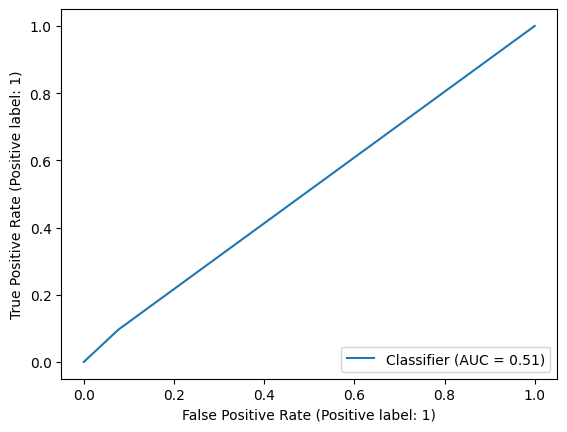

In [98]:
roc_curve(y_test, y_pred)
RocCurveDisplay.from_predictions(y_test,y_pred)

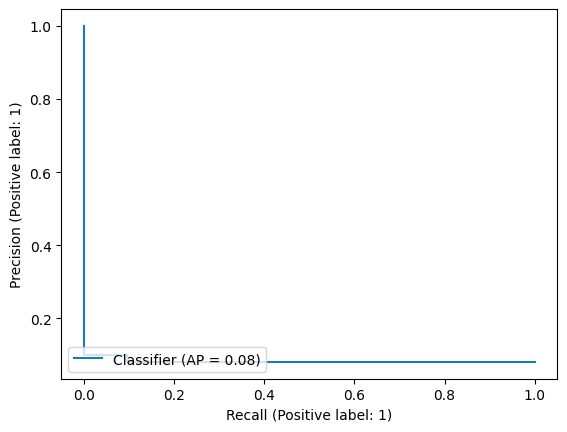

In [99]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred)

Let's also see how this translates to the client data:

In [100]:
dfi.query(f"index in {y_test.index.tolist()}")

,client_id,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,avg_month_use
72,train_Client_10,11,572765,0,203,8,1,407,0,0,0,31955,32362,4,0,101.750000
73,train_Client_10,11,572765,0,203,8,1,815,0,0,0,37913,38728,8,0,101.875000
74,train_Client_10,11,572765,0,203,6,1,569,0,0,0,30414,30983,4,0,142.250000
75,train_Client_10,11,572765,0,207,9,1,2400,682,0,0,41532,44614,12,0,256.833333
76,train_Client_10,11,572765,0,203,8,1,188,0,0,0,40634,40822,4,0,47.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476587,train_Client_99993,10,1090709,0,202,6,1,200,879,0,0,436,1515,4,0,269.750000
4476588,train_Client_99993,40,4268059,0,5,9,1,49,0,0,0,184,233,4,1,12.250000
4476589,train_Client_99993,40,4268059,0,5,9,1,23,0,0,0,266,289,4,1,5.750000
4476590,train_Client_99993,10,1090709,0,202,9,1,770,0,0,0,14901,15671,4,0,192.500000


In [101]:
#extract suspects from y_pred

test_clients = dfi.loc[y_test.index, 'client_id'].tolist() # get all clients included in y_test

y_pred_indexed = pd.DataFrame({'y_pred' : y_pred, 'client_id' : test_clients}, index=y_test.index) # assign row indexes of test data to y_pred

#pred_suspects = y_pred_indexed.query("y_pred == True").client_id.tolist()
#better line suggested by Bito:

pred_suspects = y_pred_indexed[y_pred_indexed["y_pred"] == True]["client_id"].values

#We can also count how many flagged invoices we get for each client, in case we want to change this threshold

num_flagged_invoices = Counter(pred_suspects)



(array([2.3869e+04, 1.0500e+02, 3.0000e+01, 8.0000e+00, 3.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1. ,  20.6,  40.2,  59.8,  79.4,  99. , 118.6, 138.2, 157.8,
        177.4, 197. ]),
 <BarContainer object of 10 artists>)

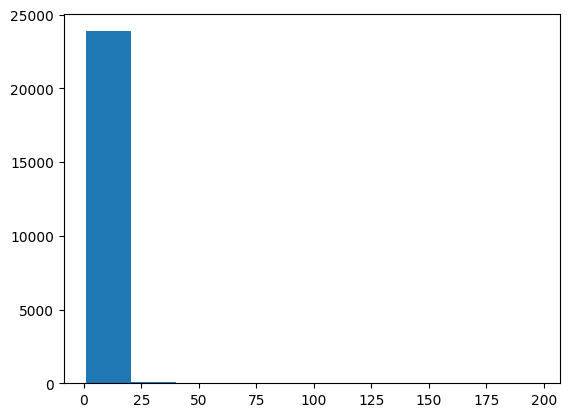

In [102]:
#histogram of the distribution of number of flagged invoices per client
plt.hist(list(num_flagged_invoices.values()))

In [103]:
#compare to list of true suspects

dfc_test_clients = dfc[dfc["client_id"].isin(set(test_clients))] # get subset of client df with clients in test set

dfc_test_clients["num_flags"] = dfc_test_clients["client_id"].map(num_flagged_invoices)

#calculate recall and precision

/var/folders/vh/9svjskkn54n5t04bltkc_8fw0000gn/T/ipykernel_11670/2191981797.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc_test_clients["num_flags"] = dfc_test_clients["client_id"].map(num_flagged_invoices)


In [104]:
dfc_test_clients.head()

,disrict,client_id,client_catg,region,creation_date,target,num_flags
2,62,train_Client_10,11,301,13/03/1986,0.0,3
5,69,train_Client_10000,11,103,29/09/1993,0.0,8
14,69,train_Client_100008,11,104,22/10/2002,0.0,0
15,63,train_Client_100009,11,311,06/11/2006,0.0,1
16,63,train_Client_10001,11,312,14/05/2002,0.0,7


In [105]:
dfc_test_clients

,disrict,client_id,client_catg,region,creation_date,target,num_flags
2,62,train_Client_10,11,301,13/03/1986,0.0,3
5,69,train_Client_10000,11,103,29/09/1993,0.0,8
14,69,train_Client_100008,11,104,22/10/2002,0.0,0
15,63,train_Client_100009,11,311,06/11/2006,0.0,1
16,63,train_Client_10001,11,312,14/05/2002,0.0,7
...,...,...,...,...,...,...,...
135470,60,train_Client_99979,11,101,17/10/2008,0.0,1
135477,60,train_Client_99985,51,101,31/12/1994,0.0,1
135479,62,train_Client_99987,11,303,05/10/2004,0.0,1
135484,63,train_Client_99991,11,311,22/05/2014,0.0,2


In [106]:
#Add predictions columns based on different thresholds

dfc_test_clients.eval("thresh_1 = num_flags >= 1", inplace=True)
dfc_test_clients.eval("thresh_2 = num_flags >= 2", inplace=True)

In [107]:
dfc_test_clients.query("target == 0").head(30)

,disrict,client_id,client_catg,region,creation_date,target,num_flags,thresh_1,thresh_2
2,62,train_Client_10,11,301,13/03/1986,0.0,3,True,True
5,69,train_Client_10000,11,103,29/09/1993,0.0,8,True,True
14,69,train_Client_100008,11,104,22/10/2002,0.0,0,False,False
15,63,train_Client_100009,11,311,06/11/2006,0.0,1,True,False
16,63,train_Client_10001,11,312,14/05/2002,0.0,7,True,True
18,63,train_Client_100011,11,311,10/02/2012,0.0,7,True,True
20,62,train_Client_100013,11,305,20/02/2001,0.0,10,True,True
22,63,train_Client_100015,11,311,30/11/1999,0.0,2,True,True
26,69,train_Client_100019,11,104,07/11/1983,0.0,2,True,True
28,60,train_Client_100020,11,101,08/12/2003,0.0,3,True,True


In [108]:
# now we can finally calculate the scores based on these

y_true = dfc_test_clients.target.values
y_pred_thresh1 = dfc_test_clients.thresh_1.values
y_pred_thresh2 = dfc_test_clients.thresh_2.values


In [109]:
y_pred_thresh1

array([ True,  True, False, ...,  True,  True,  True])

In [110]:
print("Recall score threshold 1: {}%".format(round(recall_score(y_true,y_pred_thresh1) * 100, 2)))

print("Precision score threshold 1: {}%".format(round(precision_score(y_true,y_pred_thresh1) * 100, 2)))

print("Recall score threshold 2: {}%".format(round(recall_score(y_true,y_pred_thresh2) * 100, 2)))

print("Precision score threshold 2: {}%".format(round(precision_score(y_true,y_pred_thresh2) * 100, 2)))

Recall score threshold 1: 91.23%
Precision score threshold 1: 7.19%
Recall score threshold 2: 79.44%
Precision score threshold 2: 8.3%


Not very encouraging - on our test data, when we transfer our predictions to the clients our precision is marginally better than our original baseline model, and in both cases our recall is worse...

Text(0.5, 1.0, 'ROC for threshold = 1 flagged invoice')

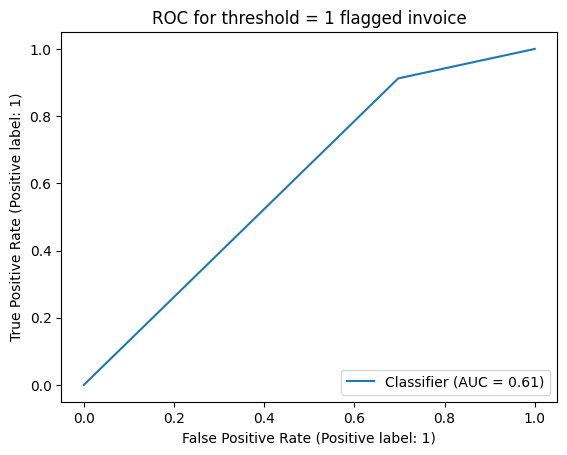

In [111]:
RocCurveDisplay.from_predictions(y_true,y_pred_thresh1)
plt.title("ROC for threshold = 1 flagged invoice")

Text(0.5, 1.0, 'ROC for threshold = 2 flagged invoices')

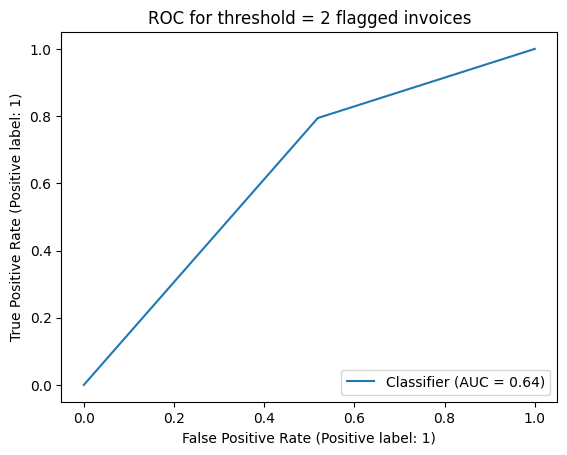

In [112]:
RocCurveDisplay.from_predictions(y_true,y_pred_thresh2)
plt.title("ROC for threshold = 2 flagged invoices")

In [113]:
tree.tree_.max_depth

133

In [114]:
from sklearn.tree import plot_tree

[Text(0.4608960543766578, 0.9583333333333334, 'x[11] <= 1.5\ngini = 0.144\nsamples = 3366088\nvalue = [3102749, 263339]'),
 Text(0.20431138096816975, 0.875, 'x[2] <= 437.5\ngini = 0.31\nsamples = 83204\nvalue = [67233, 15971]'),
 Text(0.10611806476569408, 0.7916666666666666, 'x[2] <= 7.5\ngini = 0.349\nsamples = 65179\nvalue = [50476, 14703]'),
 Text(0.046667771883289126, 0.7083333333333334, 'x[3] <= 7.0\ngini = 0.432\nsamples = 8364\nvalue = [5725, 2639]'),
 Text(0.02061229000884173, 0.625, 'x[10] <= 59219.5\ngini = 0.386\nsamples = 4252\nvalue = [3141, 1111]'),
 Text(0.020170203359858533, 0.5416666666666666, 'x[10] <= 42040.5\ngini = 0.403\nsamples = 3970\nvalue = [2859, 1111]'),
 Text(0.011715296198054819, 0.4583333333333333, 'x[13] <= 323.5\ngini = 0.389\nsamples = 3676\nvalue = [2704, 972]'),
 Text(0.0062997347480106105, 0.375, 'x[10] <= 3042.5\ngini = 0.363\nsamples = 2846\nvalue = [2167, 679]'),
 Text(0.0035366931918656055, 0.2916666666666667, 'x[10] <= 1790.5\ngini = 0.406\nsam

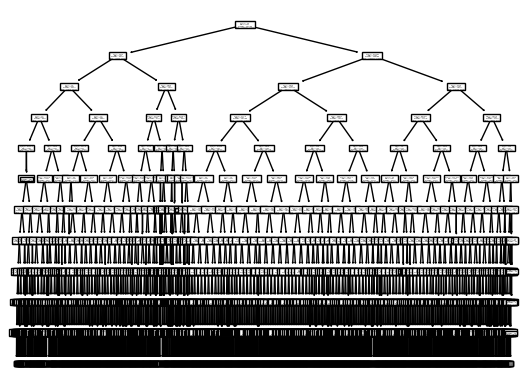

In [115]:
plot_tree(tree, max_depth=10)

In [116]:
X.columns.tolist()

AttributeError: 'Series' object has no attribute 'columns'

In [117]:
tree.feature_importances_

array([5.41326905e-03, 3.77770048e-03, 1.73972051e-02, 1.63369079e-02,
       8.09333709e-06, 1.04953842e-01, 2.50870731e-02, 5.29182338e-03,
       8.62717981e-03, 3.25136677e-01, 3.28080754e-01, 1.27843802e-02,
       3.42800154e-04, 1.46762295e-01])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'tarif_type'),
  Text(1, 0, 'counter_number'),
  Text(2, 0, 'counter_statue'),
  Text(3, 0, 'counter_code'),
  Text(4, 0, 'reading_remarque'),
  Text(5, 0, 'counter_coefficient'),
  Text(6, 0, 'consommation_level_1'),
  Text(7, 0, 'consommation_level_2'),
  Text(8, 0, 'consommation_level_3'),
  Text(9, 0, 'consommation_level_4'),
  Text(10, 0, 'old_index'),
  Text(11, 0, 'new_index'),
  Text(12, 0, 'months_number'),
  Text(13, 0, 'counter_type'),
  Text(14, 0, 'avg_month_use')])

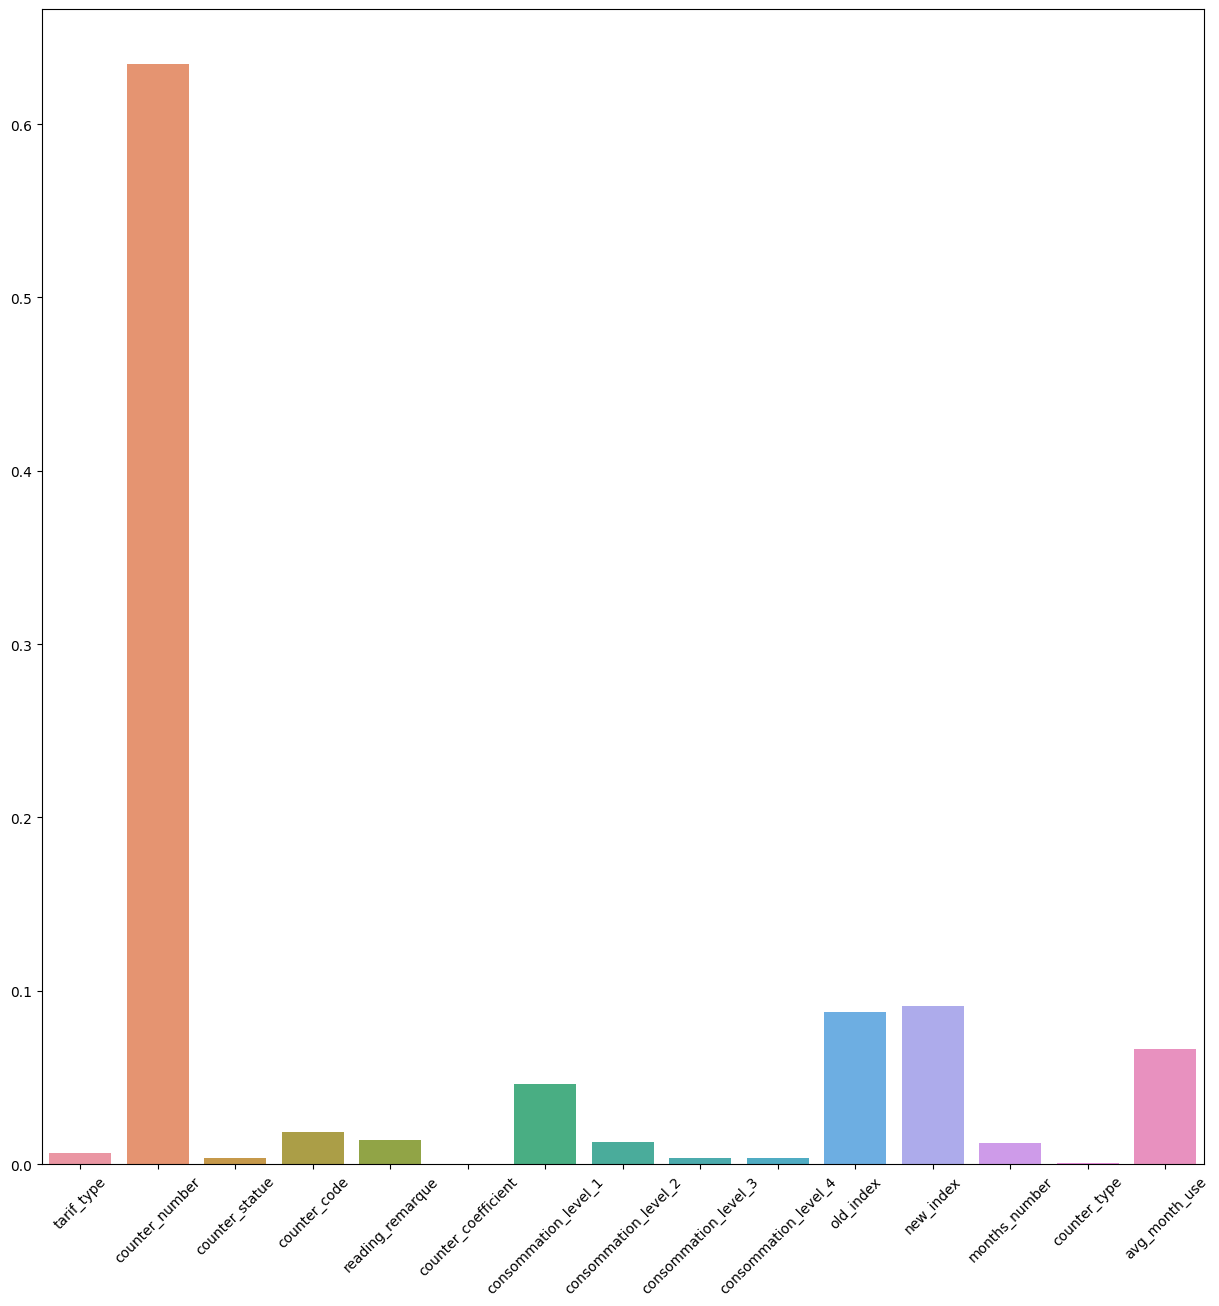

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))

ax = sns.barplot(x=X.columns.tolist(), y=tree.feature_importances_)
plt.xticks(rotation=45)


Uh oh...our most important feature is the counter number...that's probably basically an identifier for the client ID in the end...

We also want to make sure our train and test data is split so that either one of the following conditions are true:

* We have our clients separated cleanly across the train and test (so we are predicting solely for 'new' clients rather than clients based on their own behaviour)

* All of our test data is later invoices for a given customer (so we are not predicting their past behaviour based on later behaviour)

Back to the drawing board...

In [ ]:
list_of_targets = dfc.query('target == 1').client_id.tolist()
y = pd.Series(dfi.client_id.isin(list_of_targets))

In [ ]:
#We can use train_test_split on the client ids to ensure separation of clients between train and test
clients_train, clients_test, target_train, target_test = train_test_split(dfc.client_id, dfc.target, stratify=dfc.target, random_state=42)

In [120]:
X_train = dfi[dfi["client_id"].isin(set(clients_train))].drop(['client_id','counter_number', 'old_index', 'new_index', 'months_number'], axis=1) # we get rid of counter_number now

X_test = dfi[dfi["client_id"].isin(set(clients_test))].drop(['client_id','counter_number', 'old_index', 'new_index', 'months_number'], axis=1) # we get rid of counter_number now

y_train = dfi[dfi["client_id"].isin(set(clients_train))]
y_train = pd.Series(y_train.client_id.isin(list_of_targets))

y_test = dfi[dfi["client_id"].isin(set(clients_test))]
y_test = pd.Series(y_test.client_id.isin(list_of_targets))

In [121]:
len(y_test) / len(y) * 100

818.5751293424753

We end up with our test set as 25% of the data, which is alright

In [122]:
tree2 = DecisionTreeClassifier(random_state=42)

tree2.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [123]:
y_pred = tree2.predict(X_test)
y_probs = tree2.predict_proba(X_test)

In [124]:
recall_score(y_test, y_pred) * 100

2.079889191725124

In [125]:
precision_score(y_test, y_pred) * 100

15.323841659122706

So now it sucks.

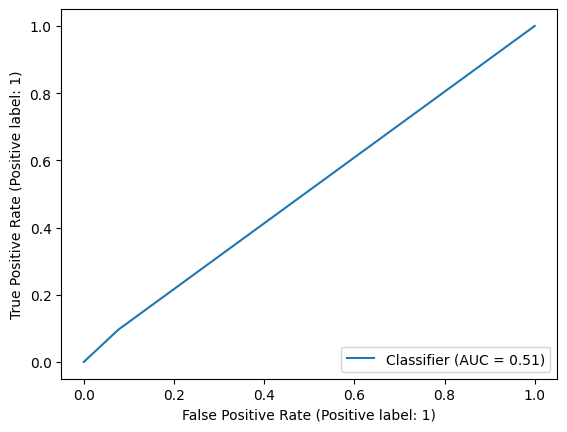

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_pred)

In [ ]:
from sklearn.metrics import make_scorer #this is used to create scoring metrics for searches

### Let's start on the grid search ###

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

In [ ]:
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'f1_score' : make_scorer(f1_score),
    'roc_auc_score': make_scorer(roc_auc_score)
}

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2,30, 2),
    'min_samples_split': range(1,20, 2),
    'min_samples_leaf': range(2,12,2)
}

randsearch = RandomizedSearchCV(estimator=tree2, param_distributions=param_grid, cv=5, n_iter=60, n_jobs=-1, verbose=2, scoring=scorers, refit='roc_auc_score')

In [ ]:
randsearch.fit(X_train, y_train,)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END criterion=entropy, max_depth=12, min_samples_leaf=8, min_samples_split=1; total time=   0.3s
[CV] END criterion=entropy, max_depth=12, min_samples_leaf=8, min_samples_split=1; total time=   0.4s
[CV] END criterion=entropy, max_depth=12, min_samples_leaf=8, min_samples_split=1; total time=   0.4s
[CV] END criterion=entropy, max_depth=12, min_samples_leaf=8, min_samples_split=1; total time=   0.5s
[CV] END criterion=entropy, max_depth=12, min_samples_leaf=8, min_samples_split=1; total time=   0.5s
[CV] END criterion=gini, max_depth=18, min_samples_leaf=4, min_samples_split=3; total time=  25.5s
[CV] END criterion=gini, max_depth=18, min_samples_leaf=4, min_samples_split=3; total time=  25.9s
[CV] END criterion=gini, max_depth=18, min_samples_leaf=4, min_samples_split=3; total time=  26.0s
[CV] END criterion=gini, max_depth=18, min_samples_leaf=4, min_samples_split=3; total time=  26.3s
[CV] END criterion=gini, max_dep

/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

[CV] END criterion=entropy, max_depth=4, min_samples_leaf=6, min_samples_split=9; total time=   9.1s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=6, min_samples_split=9; total time=   8.7s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=6, min_samples_split=9; total time=   9.1s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=4, min_samples_leaf=6, min_samples_split=9; total time=   9.1s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=4, min_samples_leaf=6, min_samples_split=9; total time=   9.5s
[CV] END criterion=gini, max_depth=22, min_samples_leaf=10, min_samples_split=5; total time=  34.3s
[CV] END criterion=gini, max_depth=22, min_samples_leaf=10, min_samples_split=5; total time=  34.6s
[CV] END criterion=entropy, max_depth=26, min_samples_leaf=2, min_samples_split=5; total time=  41.0s
[CV] END criterion=entropy, max_depth=26, min_samples_leaf=2, min_samples_split=5; total time=  40.6s
[CV] END criterion=entropy, max_depth=26, min_samples_leaf=2, min_samples_split=5; total time=  41.0s
[CV] END criterion=entropy, max_depth=26, min_samples_leaf=2, min_samples_split=5; total time=  41.0s
[CV] END criterion=entropy, max_depth=24, min_samples_leaf=8, min_samples_split=11; total time=  37.4s
[CV] END criterion=entropy, max_depth=26, min_samples_leaf=2, min_samples_split=5; total time=  40.6s
[CV] END criterion=entropy, max_depth=24, min_samples_leaf=8, min_samples_split=11; to

/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=4, min_samples_leaf=6, min_samples_split=5; total time=   9.1s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=4, min_samples_leaf=6, min_samples_split=5; total time=   9.3s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=4, min_samples_leaf=6, min_samples_split=5; total time=   8.6s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=6, min_samples_split=5; total time=   8.4s
[CV] END criterion=entropy, max_depth=22, min_samples_leaf=4, min_samples_split=15; total time=  37.1s
[CV] END criterion=entropy, max_depth=28, min_samples_leaf=6, min_samples_split=9; total time=  42.9s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=4, min_samples_leaf=6, min_samples_split=5; total time=   9.2s
[CV] END criterion=entropy, max_depth=28, min_samples_leaf=6, min_samples_split=9; total time=  42.9s
[CV] END criterion=entropy, max_depth=28, min_samples_leaf=6, min_samples_split=9; total time=  44.3s
[CV] END criterion=entropy, max_depth=28, min_samples_leaf=6, min_samples_split=9; total time=  43.9s
[CV] END criterion=entropy, max_depth=28, min_samples_leaf=6, min_samples_split=9; total time=  43.8s
[CV] END criterion=gini, max_depth=8, min_samples_leaf=10, min_samples_split=19; total time=  14.5s
[CV] END criterion=gini, max_depth=8, min_samples_leaf=10, min_samples_split=19; total time=  14.5s
[CV] END criterion=gini, max_depth=8, min_samples_leaf=10, min_samples_split=19; total time=  14.6s
[CV] END criterion=gini, max_depth=22, min_samples_leaf=10, min_samples_split=1; total time=   0.3s
[CV] END criterion=gini, max_depth=22, min_samples_leaf=10, min_samples_split=1; total time

/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=11; total time=   5.3s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=6, min_samples_split=5; total time=  19.0s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=11; total time=   5.4s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=11; total time=   5.6s
[CV] END criterion=entropy, max_depth=28, min_samples_leaf=4, min_samples_split=9; total time=  44.1s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=11; total time=   5.4s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=gini, max_depth=10, min_samples_leaf=6, min_samples_split=5; total time=  18.3s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=11; total time=   5.3s
[CV] END criterion=entropy, max_depth=16, min_samples_leaf=8, min_samples_split=1; total time=   0.3s
[CV] END criterion=entropy, max_depth=16, min_samples_leaf=8, min_samples_split=1; total time=   0.3s
[CV] END criterion=entropy, max_depth=16, min_samples_leaf=8, min_samples_split=1; total time=   0.4s
[CV] END criterion=entropy, max_depth=16, min_samples_leaf=8, min_samples_split=1; total time=   0.4s
[CV] END criterion=entropy, max_depth=16, min_samples_leaf=8, min_samples_split=1; total time=   0.3s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=gini, max_depth=4, min_samples_leaf=2, min_samples_split=17; total time=   9.0s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=6, min_samples_split=5; total time=  19.3s
[CV] END criterion=entropy, max_depth=28, min_samples_leaf=4, min_samples_split=9; total time=  44.7s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=2, min_samples_split=17; total time=   9.4s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=gini, max_depth=4, min_samples_leaf=2, min_samples_split=17; total time=   9.2s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=2, min_samples_split=17; total time=   9.3s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=2, min_samples_split=17; total time=   9.4s
[CV] END criterion=gini, max_depth=12, min_samples_leaf=8, min_samples_split=17; total time=  22.7s
[CV] END criterion=gini, max_depth=12, min_samples_leaf=8, min_samples_split=17; total time=  22.3s
[CV] END criterion=gini, max_depth=12, min_samples_leaf=8, min_samples_split=17; total time=  22.3s
[CV] END criterion=gini, max_depth=12, min_samples_leaf=8, min_samples_split=17; total time=  23.0s
[CV] END criterion=gini, max_depth=12, min_samples_leaf=8, min_samples_split=17; total time=  22.6s
[CV] END criterion=gini, max_depth=16, min_samples_leaf=4, min_samples_split=9; total time=  29.7s
[CV] END criterion=gini, max_depth=16, min_samples_leaf=4, min_samples_split=9; total time=  28.7s
[CV] 

/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=5; total time=   5.4s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=5; total time=   5.4s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=6, min_samples_split=19; total time=  19.1s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=5; total time=   5.0s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=5; total time=   4.9s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=5; total time=   5.2s
[CV] END criterion=entropy, max_depth=22, min_samples_leaf=8, min_samples_split=11; total time=  38.3s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=8, min_samples_split=5; total time=  18.9s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=8, min_samples_split=5; total time=  19.8s
[CV] END criterion=entropy, max_depth=22, min_samples_leaf=8, min_samples_split=11; total time=  37.5s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=8, min_samples_split=5; total time=  19.1s
[CV] END criterion=entropy, max_depth=22, min_samples_leaf=8, min_samples_split=11; total time=  37.1s
[CV] END criterion=entropy, max_depth=22, min_samples_leaf=8, min_samples_split=11; total time=  37.6s
[CV] END criterion=entropy, max_depth=22, min_samples_leaf=8, min_samples_split=11; total time=  37.2s
[CV] END criterion=entropy, max_depth=6, min_samples_leaf=6, min_samples_split

/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=17; total time=   5.1s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=17; total time=   5.2s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=17; total time=   5.0s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=8, min_samples_split=1; total time=   0.3s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=8, min_samples_split=1; total time=   0.3s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=8, min_samples_split=1; total time=   0.3s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=8, min_samples_split=1; total time=   0.3s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=8, min_samples_split=1; total time=   0.3s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=17; total time=   5.2s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=17; total time=   5.2s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=15; total time=   5.1s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=15; total time=   5.7s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=15; total time=   5.5s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=gini, max_depth=22, min_samples_leaf=2, min_samples_split=5; total time=  35.6s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=15; total time=   5.8s
[CV] END criterion=gini, max_depth=22, min_samples_leaf=2, min_samples_split=5; total time=  36.4s
[CV] END criterion=gini, max_depth=22, min_samples_leaf=2, min_samples_split=5; total time=  35.9s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=15; total time=   5.8s
[CV] END criterion=gini, max_depth=22, min_samples_leaf=2, min_samples_split=5; total time=  35.9s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=3; total time=   5.7s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=3; total time=   5.6s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=3; total time=   5.2s
[CV] END criterion=entropy, max_depth=8, min_samples_leaf=6, min_samples_split=3; total time=  16.9s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=3; total time=   5.5s
[CV] END criterion=gini, max_depth=22, min_samples_leaf=2, min_samples_split=5; total time=  36.8s
[CV] END criterion=entropy, max_depth=8, min_samples_leaf=6, min_samples_split=3; total time=  16.7s
[CV] END criterion=entropy, max_depth=8, min_samples_leaf=6, min_samples_split=3; total time=  16.9s
[CV] END criterion=entropy, max_depth=8, min_samples_leaf=6, min_samples_split=3; total time=  16.2s
[CV] END criterion=entropy, max_depth=8, min_samples_leaf=6, min_samples_split=3; total time=  17.0s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=3; total time=   5.4s
[CV] END criterion=gini, max_depth=14, min_samples_leaf=2, min_samples_split=15; total time=  24.1s
[CV] END criterion=gini, max_depth=14, min_samples_leaf=2, min_samples_split=15; total time=  24.5s
[CV] END criterion=entropy, max_depth=16, min_samples_leaf=6, min_samples_split=3; total time=  28.2s
[CV] END criterion=gini, max_depth=14, min_samples_leaf=2, min_samples_split=15; total time=  24.1s
[CV] END criterion=entropy, max_depth=16, min_samples_leaf=6, min_samples_split=3; total time=  28.9s
[CV] END criterion=entropy, max_depth=16, min_samples_leaf=6, min_samples_split=3; total time=  28.7s
[CV] END criterion=entropy, max_depth=16, min_samples_leaf=6, min_samples_split=3; total time=  29.1s
[CV] END criterion=entropy, max_depth=16, min_samples_leaf=6, min_samples_split=3; total time=  28.9s
[CV] END criterion=gini, max_depth=14, min_samples_leaf=2, min_samples_split=15; total ti

/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=gini, max_depth=2, min_samples_leaf=10, min_samples_split=7; total time=   6.0s
[CV] END criterion=gini, max_depth=8, min_samples_leaf=8, min_samples_split=13; total time=  18.0s
[CV] END criterion=gini, max_depth=8, min_samples_leaf=8, min_samples_split=13; total time=  17.6s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=gini, max_depth=2, min_samples_leaf=10, min_samples_split=7; total time=   5.8s
[CV] END criterion=entropy, max_depth=18, min_samples_leaf=8, min_samples_split=5; total time=  35.0s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=18, min_samples_leaf=8, min_samples_split=5; total time=  34.8s
[CV] END criterion=gini, max_depth=8, min_samples_leaf=8, min_samples_split=13; total time=  17.8s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=10, min_samples_split=7; total time=   5.5s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=10, min_samples_split=7; total time=   5.9s


/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=gini, max_depth=2, min_samples_leaf=10, min_samples_split=7; total time=   5.9s
[CV] END criterion=gini, max_depth=8, min_samples_leaf=8, min_samples_split=13; total time=  18.1s
[CV] END criterion=entropy, max_depth=18, min_samples_leaf=8, min_samples_split=5; total time=  35.6s
[CV] END criterion=gini, max_depth=8, min_samples_leaf=2, min_samples_split=9; total time=  15.3s
[CV] END criterion=gini, max_depth=8, min_samples_leaf=2, min_samples_split=9; total time=  15.5s
[CV] END criterion=gini, max_depth=8, min_samples_leaf=2, min_samples_split=9; total time=  15.8s
[CV] END criterion=gini, max_depth=8, min_samples_leaf=2, min_samples_split=9; total time=  17.1s
[CV] END criterion=gini, max_depth=8, min_samples_leaf=2, min_samples_split=9; total time=  17.0s
[CV] END criterion=entropy, max_depth=8, min_samples_leaf=4, min_samples_split=5; total time=  16.8s
[CV] END criterion=entropy, max_depth=24, min_samples_leaf=10, min_samples_split=11; total time=  42.5s
[CV] 

/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3.11/site-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/Users/annawey/git/NeueFische/Fraud-Detection-ML/.venv/lib/python3

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(2, 30, 2),
                                        'min_samples_leaf': range(2, 12, 2),
                                        'min_samples_split': range(1, 20, 2)},
                   refit='roc_auc_score',
                   scoring={'f1_score': make_scorer(f1_score),
                            'precision_score': make_scorer(precision_score),
                            'recall_score': make_scorer(recall_score),
                            'roc_auc_score': make_scorer(roc_auc_score)},
                   verbose=2)

to do:

Understand scoring method during search, and how to set it
how to properly refit and score output models

In [ ]:
rand_tree = randsearch.best_estimator_

In [ ]:
rand_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=28, min_samples_leaf=6, min_samples_split=11,
                       random_state=42)

In [ ]:
y_pred_rand = rand_tree.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_rand))

              precision    recall  f1-score   support

       False       0.92      0.99      0.95   1019588
        True       0.16      0.03      0.04     89524

    accuracy                           0.91   1109112
   macro avg       0.54      0.51      0.50   1109112
weighted avg       0.86      0.91      0.88   1109112



In [ ]:
recall_score(y_test, y_pred_rand)

0.025926008668066665

In [ ]:
rand_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 28,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 6,
 'min_samples_split': 11,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

### Random Forest time

In [ ]:
forest = RandomForestClassifier(n_estimators=100,
                                random_state=42,
                                max_features='sqrt',
                                n_jobs=-1,
                                verbose=1)

forest.fit(X_train, y_train)

## Feature importance ##

first we will permutate the f

In [118]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

In [119]:
#Permutate all features and alayze the loss in f1 score 
result = permutation_importance(rand_tree, X_test, y_test, scoring='f1' , n_repeats=10, random_state=42, n_jobs=2)
result

{'importances_mean': array([-1.69402019e-02,  5.35652150e-05, -3.34585939e-02, -1.32381355e-03,
         0.00000000e+00, -1.55249854e-02, -2.36644570e-03,  8.14890122e-04,
         8.48556874e-04, -4.22939311e-02, -4.34664465e-02,  6.13441443e-03,
        -3.51694961e-05, -1.13000759e-02]),
 'importances_std': array([5.65080625e-04, 1.23316195e-04, 5.67386244e-04, 5.43146258e-04,
        0.00000000e+00, 5.76958086e-04, 3.01912452e-04, 7.73284772e-05,
        7.82918486e-05, 5.76121717e-04, 6.87613216e-04, 3.20597290e-04,
        1.65190198e-05, 6.24243415e-04]),
 'importances': array([[-1.69600075e-02, -1.66048802e-02, -1.64659561e-02,
         -1.61434175e-02, -1.76354806e-02, -1.69148731e-02,
         -1.65040165e-02, -1.69308068e-02, -1.70652366e-02,
         -1.81773438e-02],
        [ 2.40019662e-05,  5.38747795e-05,  3.52207945e-04,
          4.45215544e-05,  1.28669302e-04,  3.59292562e-05,
         -1.08459634e-04,  1.05572177e-04,  1.76132115e-06,
         -1.02426517e-04],
  

In [ ]:
forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

In [ ]:
f = pd.DataFrame(forest_importances, columns=['feature']).query('abs(feature) > 0.001')
f.sort_values('feature', ascending=False, inplace=True)

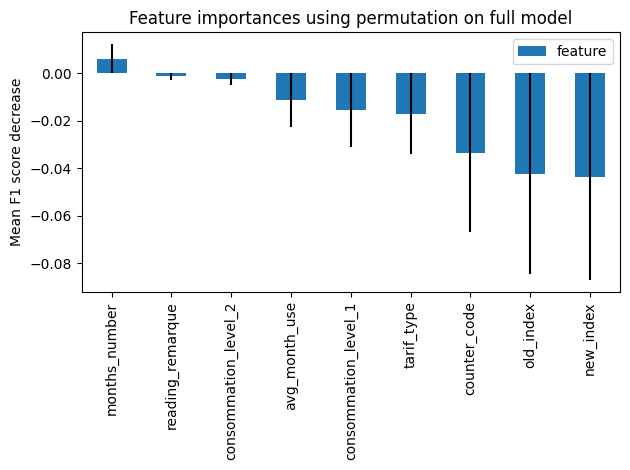

In [ ]:
fig, ax = plt.subplots()
f.plot.bar(yerr=abs(f.feature), ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean F1 score decrease")
fig.tight_layout()
plt.show()

In [ ]:
# Apparently it does not work with trees just boosting methods which makes sense 

feature_important = rand_tree.get_booster().get_score(importance_type='total_gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.nlargest(10, columns='score').plot(kind='barh', figsize = (20,10)) ## plot top 10 features

AttributeError: 'DecisionTreeClassifier' object has no attribute 'get_booster'